In [1]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = 12, 8

In [3]:
# print(torch.__version__)
# print(torch.backends.cudnn.version())
# print(torchvision.__version__)
# print(torchtext.__version__)

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False  # 启用Cudnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# 模型相关参数
PRETRAIN = False
base_model_name = 'roberta-llama3.1405B-twitter-sentiment'
TEST_DATASET_SIZE = 0.4
NUM_LABELS = 3
DATA_PATH = './data/citation_sentiment_corpus_new.csv'
if PRETRAIN:
    BASE_MODEL_PATH = f'./citation_finetuned_models/{base_model_name}_itft'
else:
    BASE_MODEL_PATH = f'./pretrain_models/{base_model_name}'

# 训练相关参数
BATCH_SIZE = 32
loss_type='focal_loss' # 自定义参数 focal_loss dsc_loss ce_loss asymmetric_loss
weight_decay = 0.05  # 0.01
lr = 2.0e-5  # 2e-5学习率，bs设置较大 5e-6
num_epochs = 5
warmup_ratio = 0.1
warmup_steps = 100
label_smoothing_factor = 0.1

# notebook_login()
os.environ["WANDB_PROJECT"] = base_model_name
os.environ["WANDB_LOG_MODEL"] = 'true' # save your trained model checkpoint to wandb
os.environ["WANDB_WATCH"] = 'false' # turn off watch to log faster

In [6]:
df = pd.read_csv(DATA_PATH)
texts = df['Citation_Text'].tolist()
labels = df['Sentiment'].tolist()
print(df.shape)
df.head()

(8699, 5)


,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text,Sentence_Length
0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,486
1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,349
2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,159
3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,368
4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,125


## 使用Trainer类微调citation的情感分析

In [7]:
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}

# 加载基座模型和分词器
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import datasets

class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=TEST_DATASET_SIZE, stratify=labels, random_state=seed)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)

train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_data = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_data = datasets.DatasetDict({'train': train_data, 'validation': val_data, 'test': test_data})
tokenized_data = emotion_data.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True)  # WordPiece分词器
# tokenized_data = tokenized_data.remove_columns(['text'])
# train_dataset = tokenized_data['train']
# val_dataset = tokenized_data['validation']
# test_dataset = tokenized_data['test']

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [9]:
# 使用Focal loss作为损失函数解决样本不均衡问题
class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyperparameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss

# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

# Asymmetric Loss
class AsymmetricLoss(torch.nn.Module):
    """ 
    Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations
    """
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'asymmetric_loss':
            loss_fct = AsymmetricLoss(gamma_pos=0.5, gamma_neg=3.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    class_weights = np.bincount(labels) / len(labels)
    sample_weights = class_weights[labels]
    weighted_accuracy = accuracy_score(labels, preds, sample_weight=sample_weights)

    return {
        'Accuracy': acc,
        'Weighted Accuracy': weighted_accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.eval_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss over Time')
        plt.show()

loss_recorder = LossRecorderCallback()

In [11]:
# # 定义训练参数
# training_args = TrainingArguments(
#     output_dir=f'./results/{base_model_name}',          # 输出结果目录
#     report_to='none',
#     num_train_epochs=num_epochs,
#     learning_rate=lr,
#     per_device_train_batch_size=BATCH_SIZE,
#     per_device_eval_batch_size=BATCH_SIZE,
#     weight_decay=weight_decay,
#     warmup_ratio=warmup_ratio,
#     # warmup_steps=warmup_steps,
#     logging_strategy='steps',
#     logging_dir=f'./logs/{base_model_name}',            # 日志目录
#     logging_steps=50,
#     eval_strategy="steps",
#     eval_steps=50,
#     disable_tqdm=False,
#     save_strategy="steps",
#     fp16= torch.cuda.is_available(), # faster and use less memory
#     metric_for_best_model='F1',
#     load_best_model_at_end=True,
#     greater_is_better=True,
#     # push_to_hub=True,
#     # label_smoothing_factor=label_smoothing_factor
# )
# 
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
#     callbacks=[loss_recorder]
# )
# 
# start = time.time()
# trainer.train()
# train_time = time.time() - start
# print(f"Training took: {train_time:.2f} seconds")
# eval_result = trainer.evaluate()
# 
# loss_recorder.plot_losses()

# k-fold cross validation

Training fold 1/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.240400,0.113360,0.881226,0.959130,0.457750,0.467208,0.452592
100,0.107100,0.095489,0.896552,0.981602,0.468122,0.548287,0.441043
150,0.088500,0.089060,0.883780,0.949053,0.493055,0.489441,0.497014
200,0.097200,0.089109,0.874840,0.932316,0.525896,0.544281,0.529486
250,0.086300,0.096305,0.879949,0.941192,0.587109,0.624468,0.582059
300,0.076800,0.081513,0.886335,0.947616,0.570570,0.607098,0.546390
350,0.061300,0.095357,0.895275,0.956664,0.550021,0.601566,0.532915
400,0.069000,0.099439,0.897829,0.954448,0.540570,0.617778,0.544193
450,0.068100,0.078524,0.886335,0.928786,0.647829,0.634590,0.663811
500,0.051400,0.080984,0.895275,0.941463,0.658882,0.662058,0.658522


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 262.87 seconds


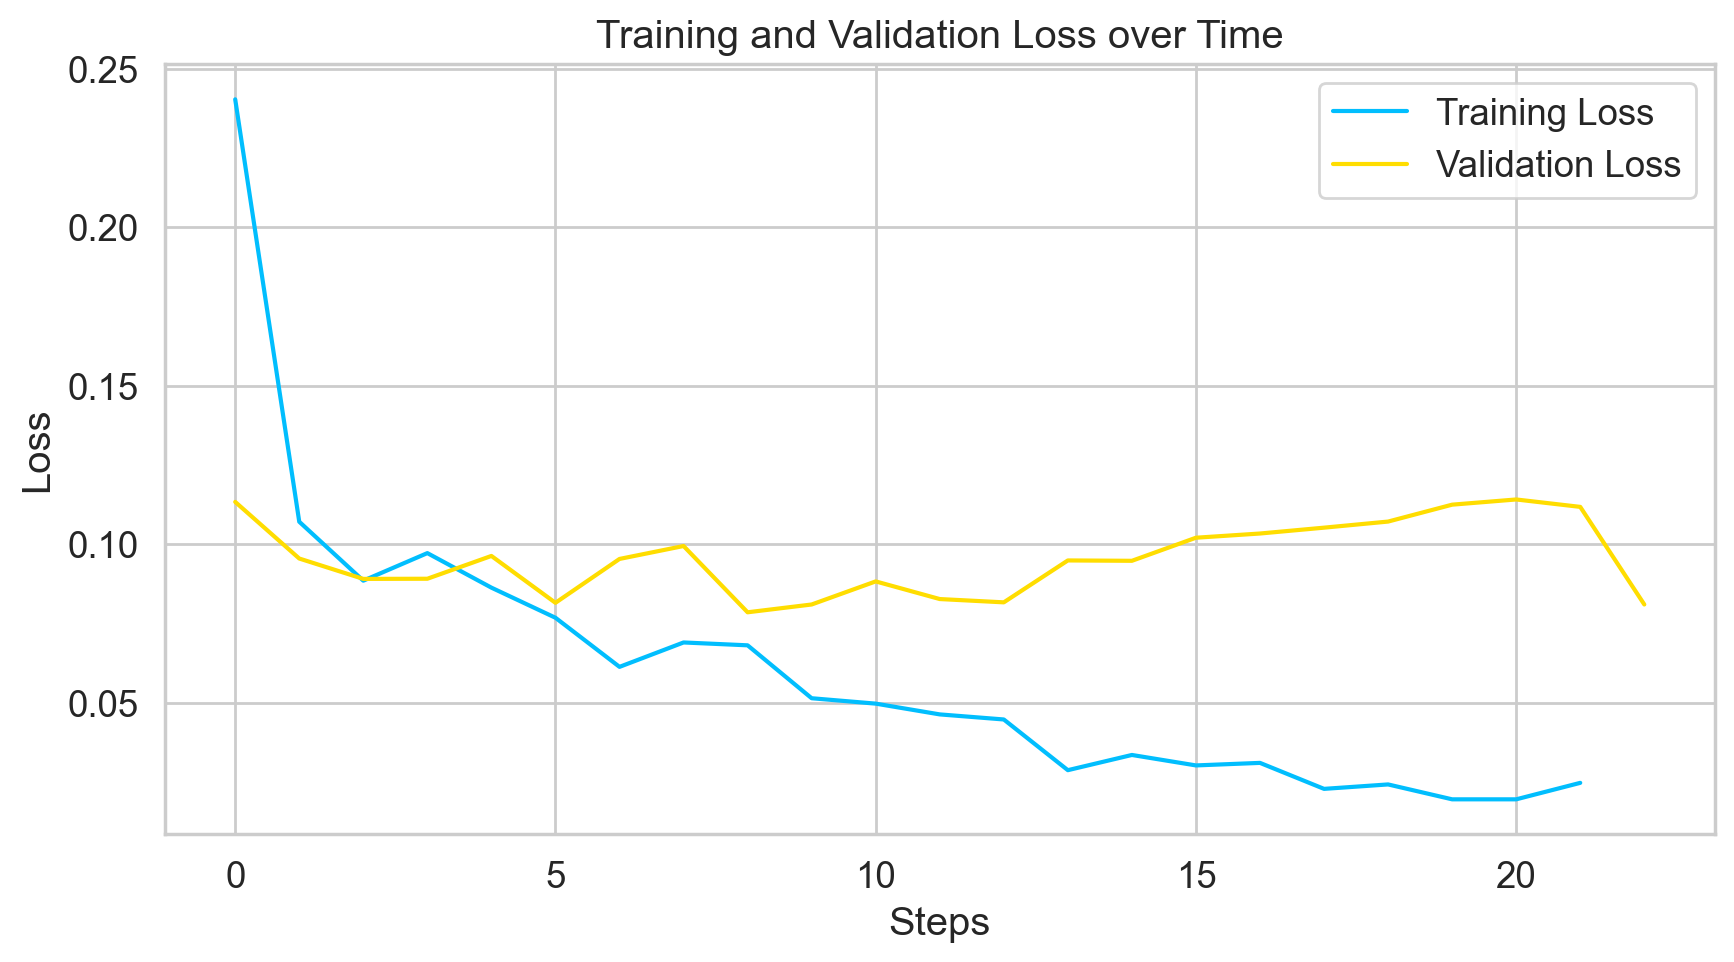

Training fold 2/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.238400,0.113217,0.874840,0.949070,0.442456,0.448271,0.439190
100,0.103300,0.101355,0.867178,0.916062,0.479421,0.455473,0.515058
150,0.097500,0.098664,0.874840,0.928520,0.482182,0.463576,0.505523
200,0.102200,0.077443,0.885057,0.946416,0.484652,0.480825,0.488664
250,0.083400,0.074507,0.869732,0.918618,0.555479,0.789108,0.547591
300,0.071100,0.073293,0.882503,0.907829,0.693209,0.731155,0.704853
350,0.075500,0.077497,0.883780,0.927661,0.612934,0.646657,0.605208
400,0.074500,0.077946,0.865900,0.899563,0.631415,0.626454,0.654875
450,0.060000,0.079298,0.897829,0.959058,0.587768,0.769939,0.539736
500,0.054900,0.086072,0.869732,0.899908,0.652385,0.642730,0.679286


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\U

Training took: 276.10 seconds


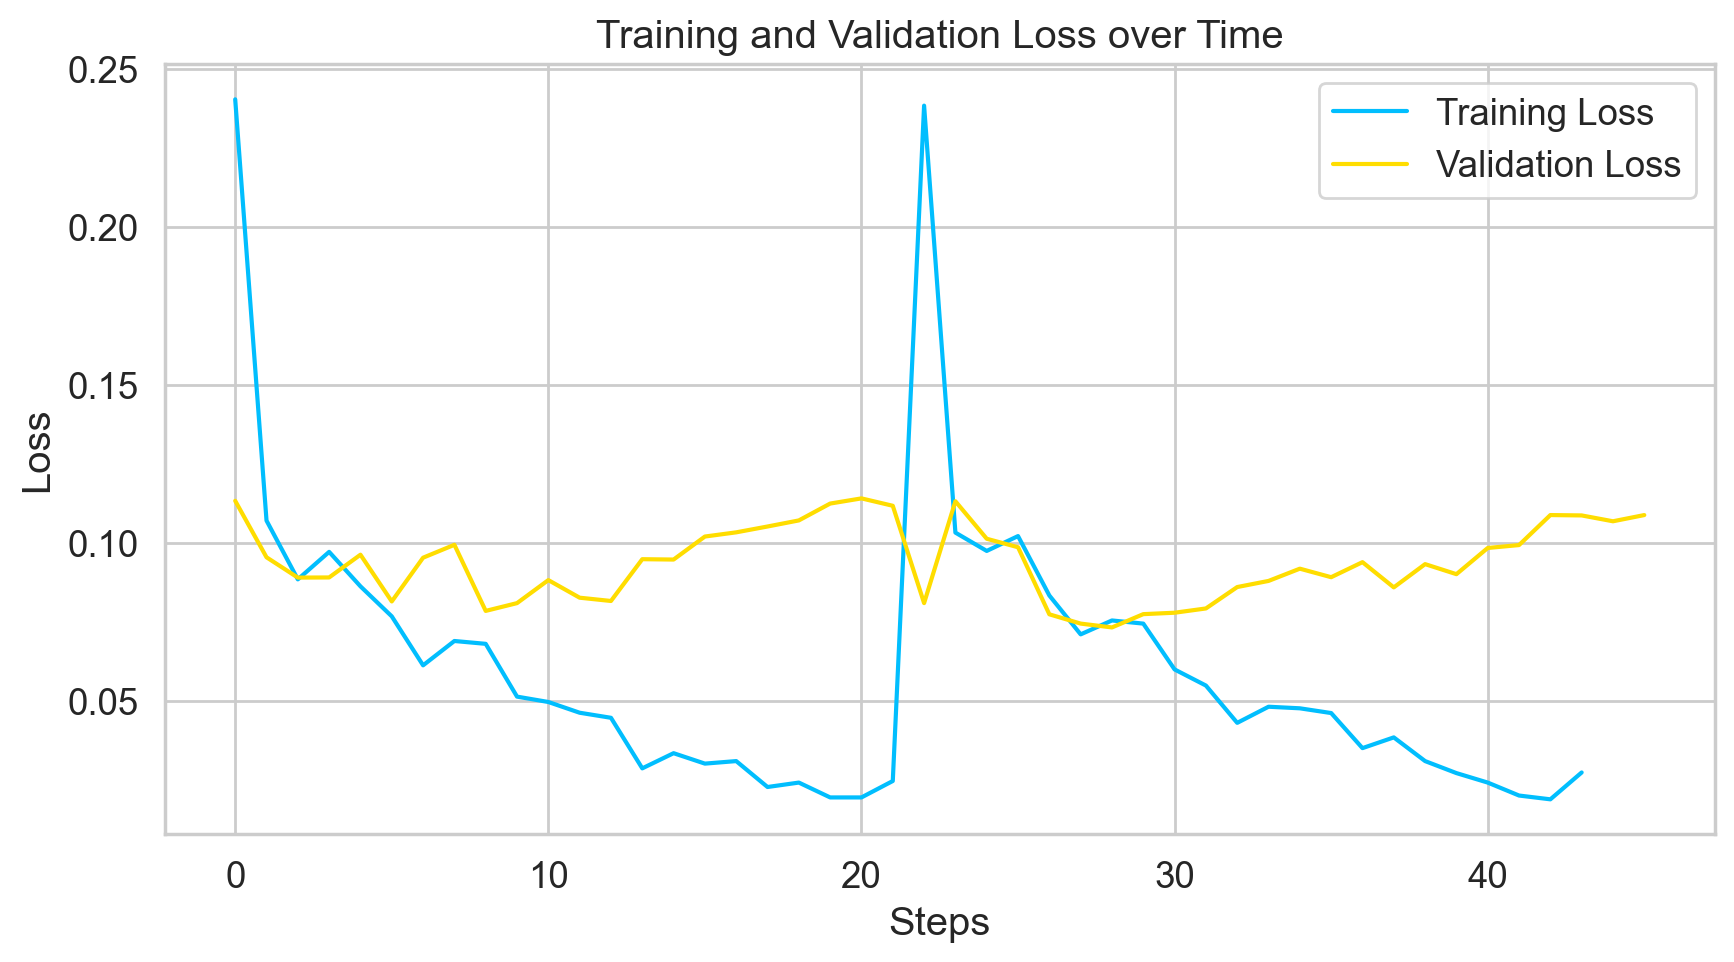

Training fold 3/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.241400,0.115612,0.877395,0.966328,0.444601,0.488722,0.428043
100,0.109400,0.091713,0.887612,0.972800,0.470897,0.532571,0.447100
150,0.094100,0.080994,0.879949,0.939126,0.578585,0.605505,0.558759
200,0.097800,0.082571,0.887612,0.968946,0.479284,0.524954,0.458448
250,0.085700,0.084290,0.887612,0.932529,0.599315,0.614878,0.598549
300,0.082000,0.083790,0.869732,0.911937,0.646585,0.621489,0.707551
350,0.071400,0.082131,0.874840,0.924278,0.634993,0.651052,0.682055
400,0.062100,0.075591,0.905492,0.962572,0.653620,0.705854,0.617896
450,0.069600,0.078979,0.892720,0.930244,0.692346,0.672691,0.747630
500,0.050400,0.085987,0.893997,0.938452,0.673883,0.666551,0.703567


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 259.67 seconds


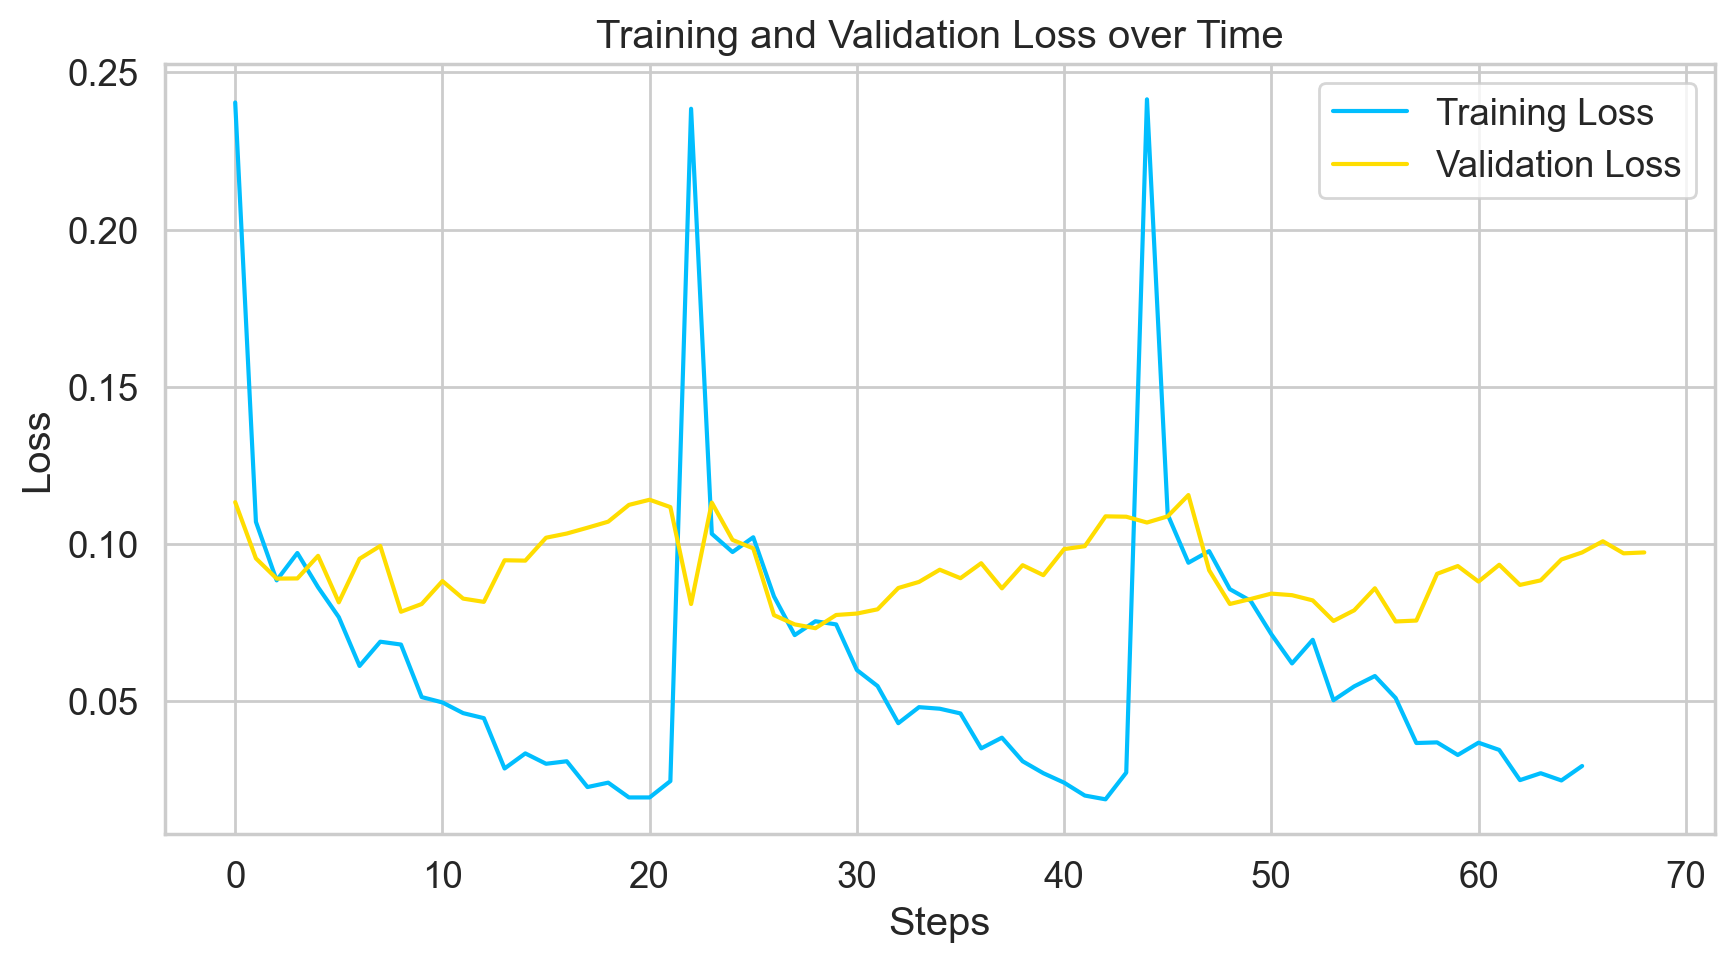

Training fold 4/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.236000,0.124228,0.848020,0.930120,0.427349,0.423879,0.431290
100,0.105500,0.100010,0.877395,0.967440,0.448978,0.496208,0.431433
150,0.105100,0.112548,0.862069,0.904328,0.593576,0.633145,0.604729
200,0.091300,0.101771,0.874840,0.947599,0.517035,0.646466,0.495152
250,0.065900,0.105535,0.867178,0.957086,0.437035,0.470562,0.423767
300,0.070400,0.104978,0.862069,0.915671,0.583860,0.581403,0.587438
350,0.067700,0.090787,0.883780,0.937947,0.607395,0.624197,0.595136
400,0.063400,0.114978,0.856960,0.893479,0.575722,0.575168,0.609541
450,0.068400,0.097108,0.874840,0.925919,0.629219,0.625883,0.636048
500,0.044900,0.110979,0.878672,0.933301,0.607592,0.621168,0.597566


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 264.80 seconds


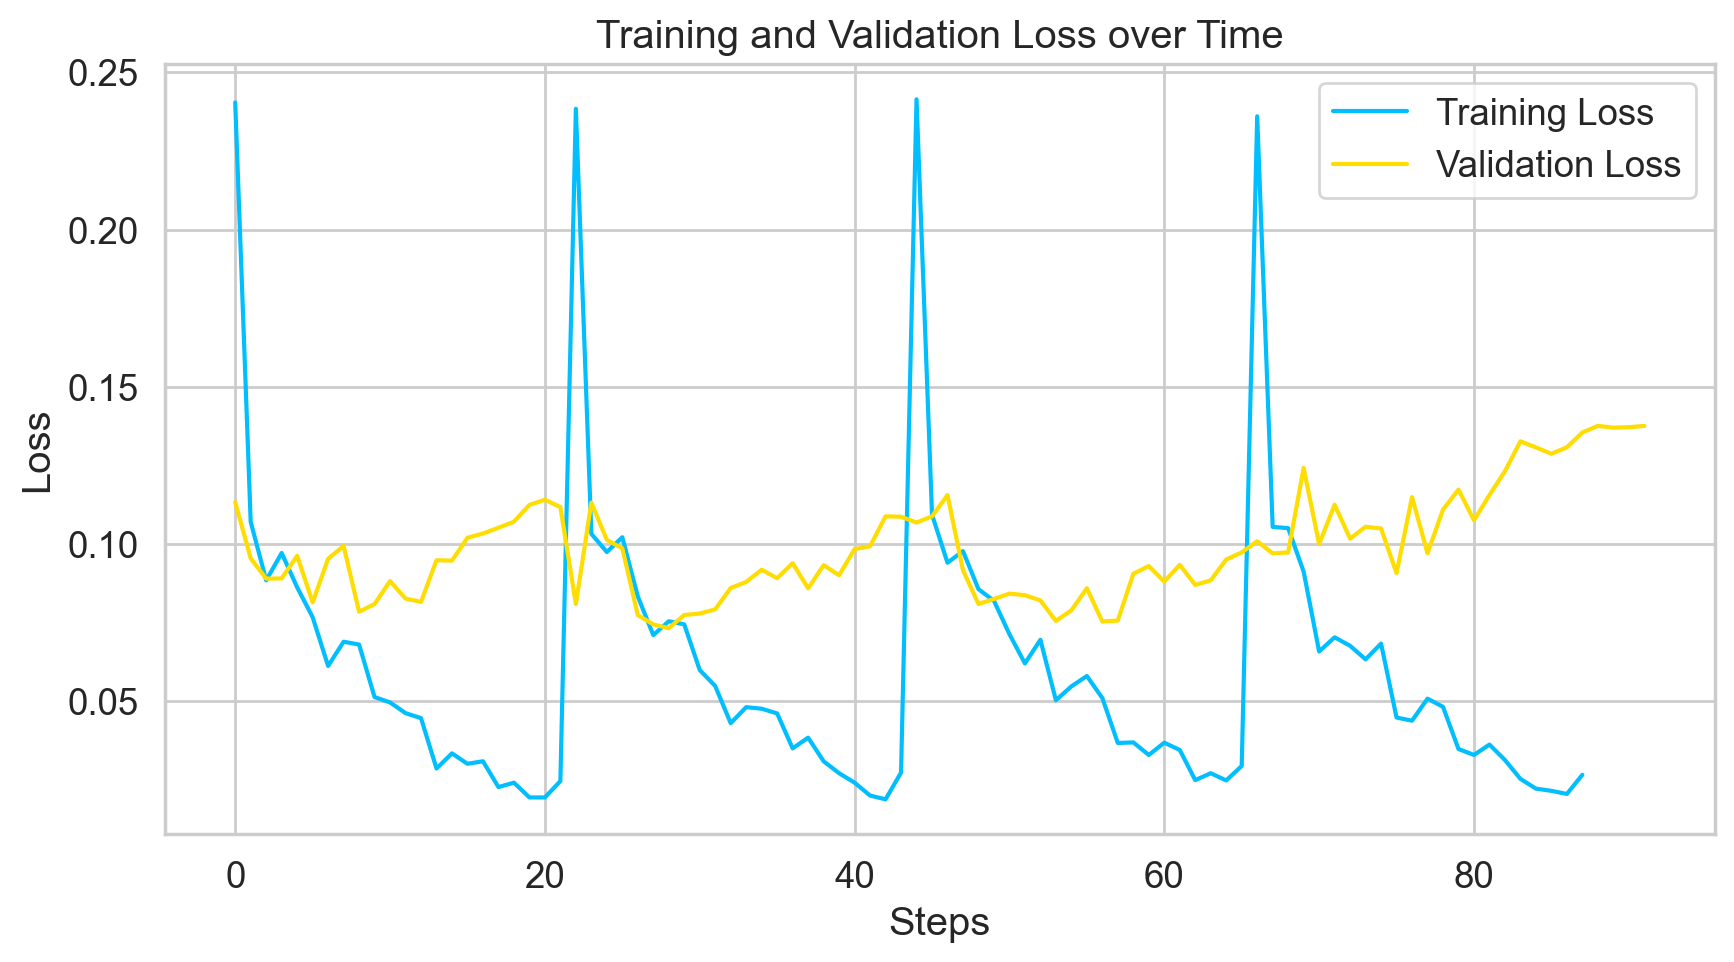

Training fold 5/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.245200,0.117013,0.879949,0.941097,0.468483,0.467439,0.469763
100,0.109900,0.081858,0.895275,0.977336,0.444008,0.534351,0.418723
150,0.102400,0.078183,0.886335,0.925396,0.508000,0.484927,0.540397
200,0.092600,0.107801,0.814815,0.826635,0.548185,0.507985,0.665719
250,0.078800,0.080746,0.893997,0.936530,0.516000,0.499423,0.535720
300,0.077300,0.077973,0.904215,0.960431,0.565429,0.612093,0.534813
350,0.070300,0.075781,0.895275,0.938846,0.583360,0.585327,0.582094
400,0.070100,0.082841,0.896552,0.944972,0.607005,0.630401,0.617098
450,0.077500,0.078680,0.905492,0.973423,0.526034,0.620445,0.484629
500,0.051100,0.084917,0.892720,0.928986,0.635449,0.616142,0.682874


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\U

Training took: 275.20 seconds


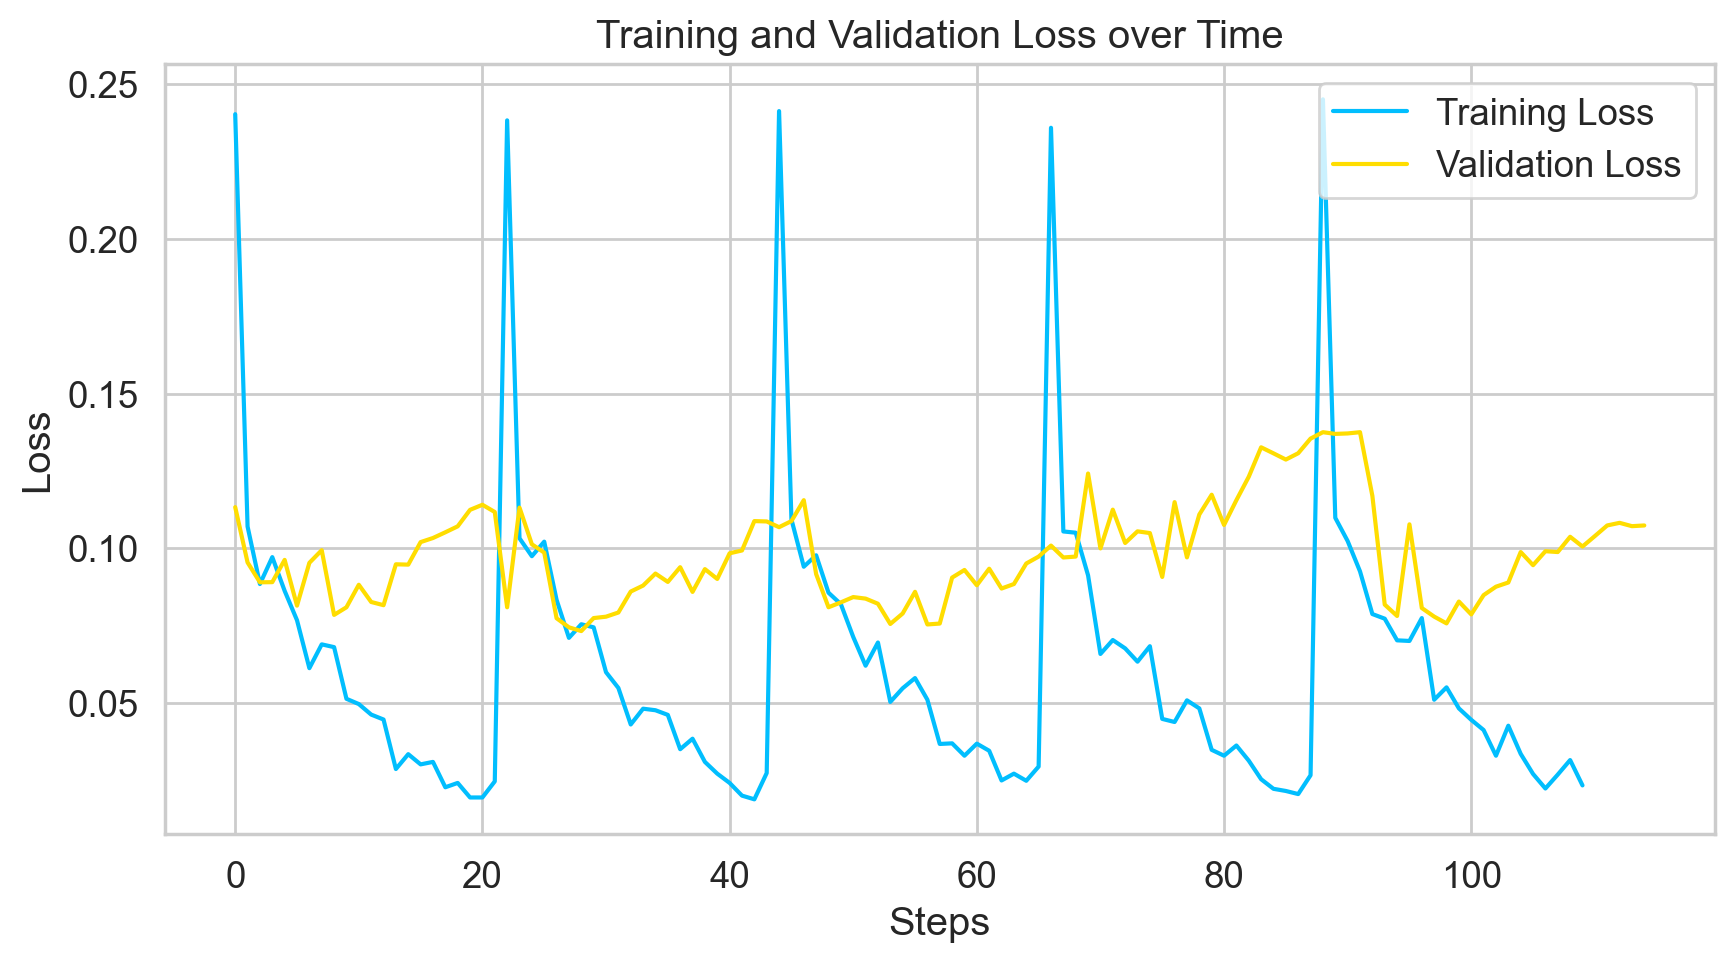

Training fold 6/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.249600,0.113737,0.886335,0.979256,0.430482,0.494695,0.412774
100,0.106900,0.096887,0.895275,0.978959,0.476304,0.539343,0.451503
150,0.089100,0.082234,0.908046,0.980392,0.521603,0.559367,0.500522
200,0.096800,0.108341,0.897829,0.988103,0.501370,0.765264,0.449027
250,0.078700,0.080447,0.901660,0.968798,0.590888,0.664231,0.548590
300,0.070400,0.089443,0.893997,0.940566,0.615215,0.626026,0.618110
350,0.075700,0.083034,0.908046,0.961476,0.645405,0.680361,0.618220
400,0.071400,0.072779,0.900383,0.947781,0.623680,0.630304,0.620543
450,0.064500,0.080610,0.908046,0.966675,0.637441,0.692667,0.600558
500,0.051600,0.074711,0.910600,0.948366,0.690073,0.680036,0.703223


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 269.04 seconds


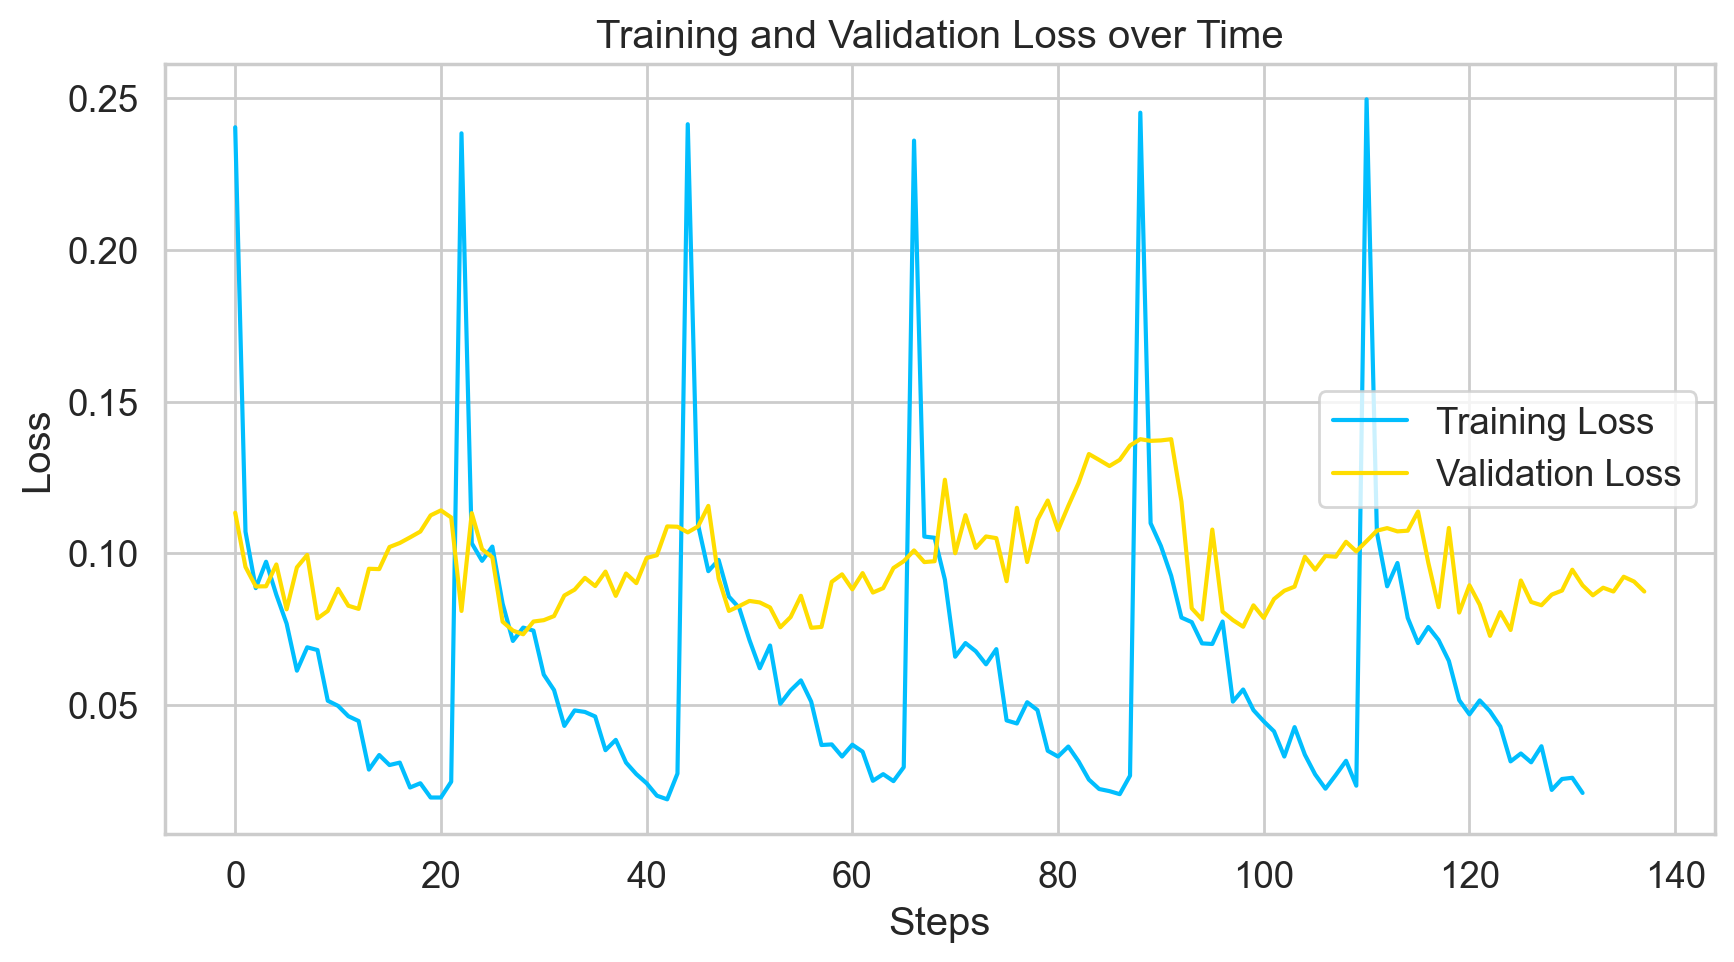

Training fold 7/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.246100,0.126854,0.864623,0.955741,0.460741,0.491034,0.447333
100,0.108800,0.101942,0.863346,0.974640,0.411934,0.529358,0.396255
150,0.103200,0.100855,0.868455,0.952527,0.476294,0.492023,0.467805
200,0.091400,0.086809,0.869732,0.960230,0.489895,0.679997,0.460744
250,0.069100,0.088729,0.878672,0.950325,0.509486,0.514539,0.506592
300,0.068500,0.092679,0.886335,0.959752,0.601364,0.806973,0.547652
350,0.076300,0.091535,0.888889,0.933134,0.655558,0.747919,0.637843
400,0.065800,0.091295,0.885057,0.926580,0.612640,0.701723,0.617933
450,0.062500,0.096755,0.881226,0.946922,0.633205,0.694429,0.594416
500,0.053800,0.097998,0.887612,0.931238,0.665978,0.677232,0.662066


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\U

Training took: 260.87 seconds


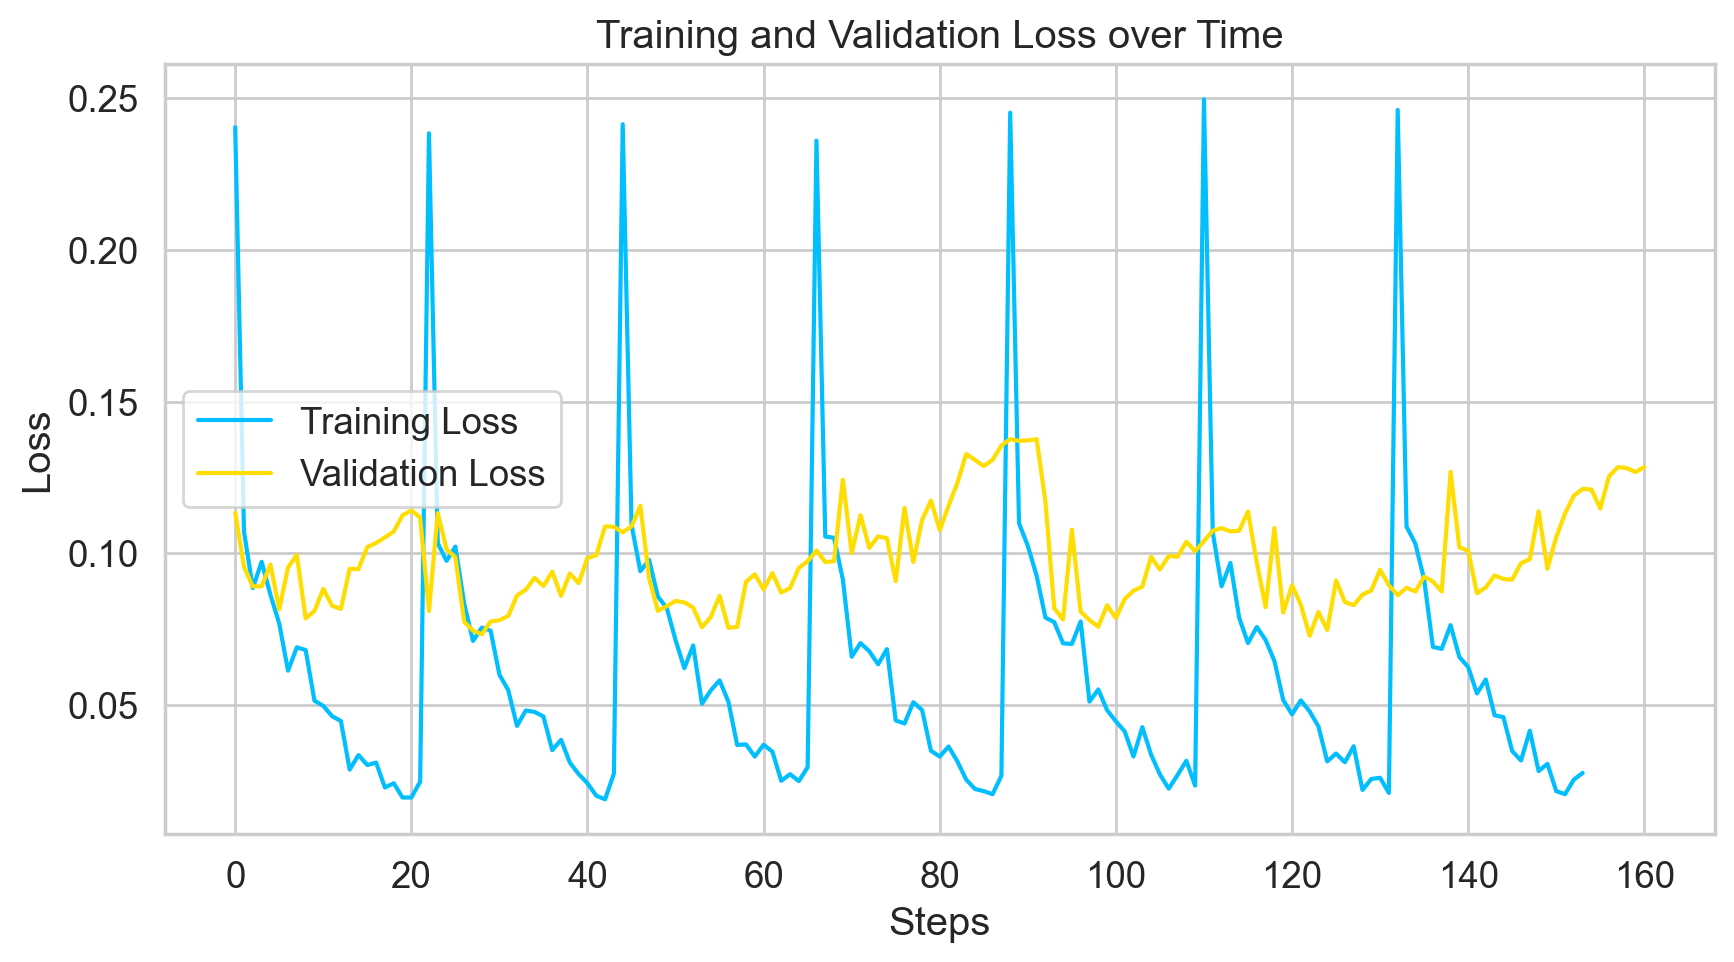

Training fold 8/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.243900,0.128351,0.859515,0.938171,0.432346,0.427658,0.437368
100,0.112800,0.104637,0.853129,0.918010,0.452325,0.433417,0.477006
150,0.093200,0.106909,0.817369,0.847359,0.536412,0.543663,0.596183
200,0.084600,0.094524,0.849298,0.889385,0.585818,0.556597,0.630589
250,0.079200,0.103776,0.859515,0.905274,0.566188,0.557797,0.585815
300,0.082100,0.095875,0.863346,0.901660,0.596747,0.584568,0.626942
350,0.075000,0.082898,0.886335,0.936438,0.628632,0.632804,0.627891
400,0.066600,0.087077,0.865900,0.901687,0.613688,0.583008,0.657961
450,0.069900,0.091518,0.871009,0.916431,0.616147,0.598659,0.637668
500,0.049700,0.100357,0.881226,0.927052,0.612181,0.615505,0.616935


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 272.51 seconds


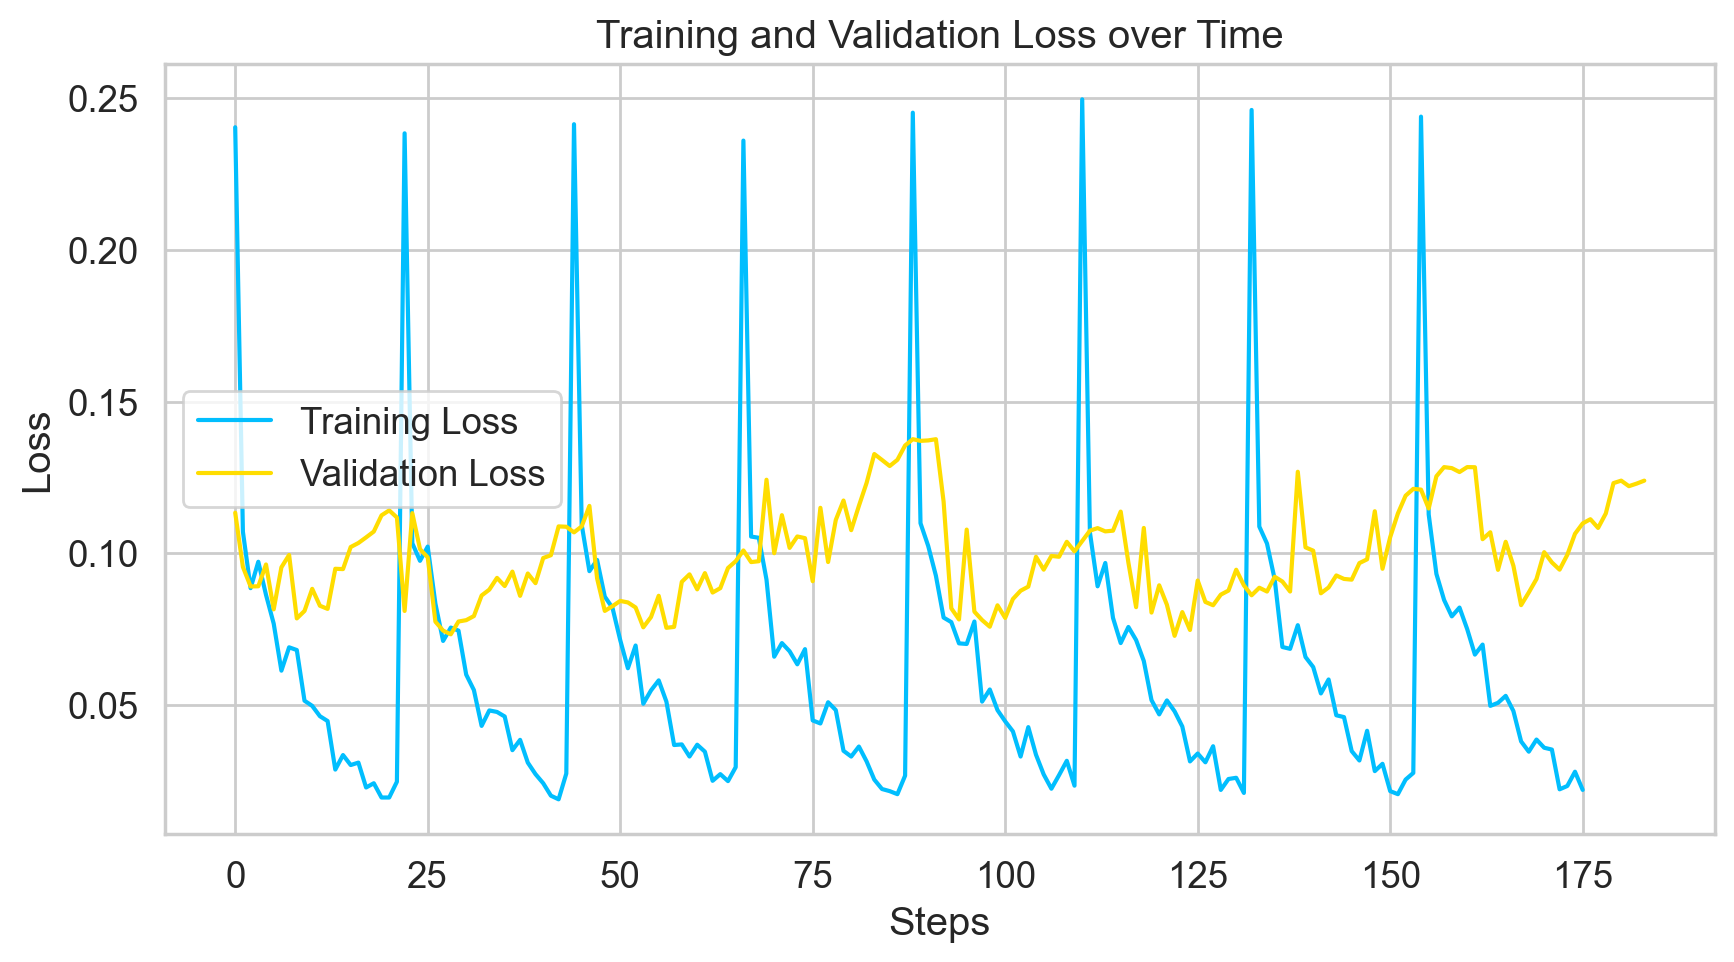

Training fold 9/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.236400,0.103330,0.877395,0.971036,0.395011,0.434573,0.386386
100,0.107200,0.080069,0.895275,0.952615,0.502951,0.491163,0.515610
150,0.093700,0.077608,0.896552,0.940784,0.601785,0.663963,0.596611
200,0.101400,0.085695,0.886335,0.942550,0.494792,0.479516,0.512213
250,0.077100,0.078072,0.893997,0.929885,0.638490,0.643433,0.649906
300,0.072700,0.074233,0.897829,0.972852,0.574085,0.700035,0.519005
350,0.075300,0.069111,0.901660,0.958443,0.662302,0.699282,0.647081
400,0.083200,0.076991,0.901660,0.955425,0.604501,0.650347,0.579911
450,0.069300,0.080100,0.900383,0.946173,0.627473,0.667782,0.613839
500,0.056500,0.077572,0.891443,0.925306,0.659475,0.633620,0.692723


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 262.75 seconds


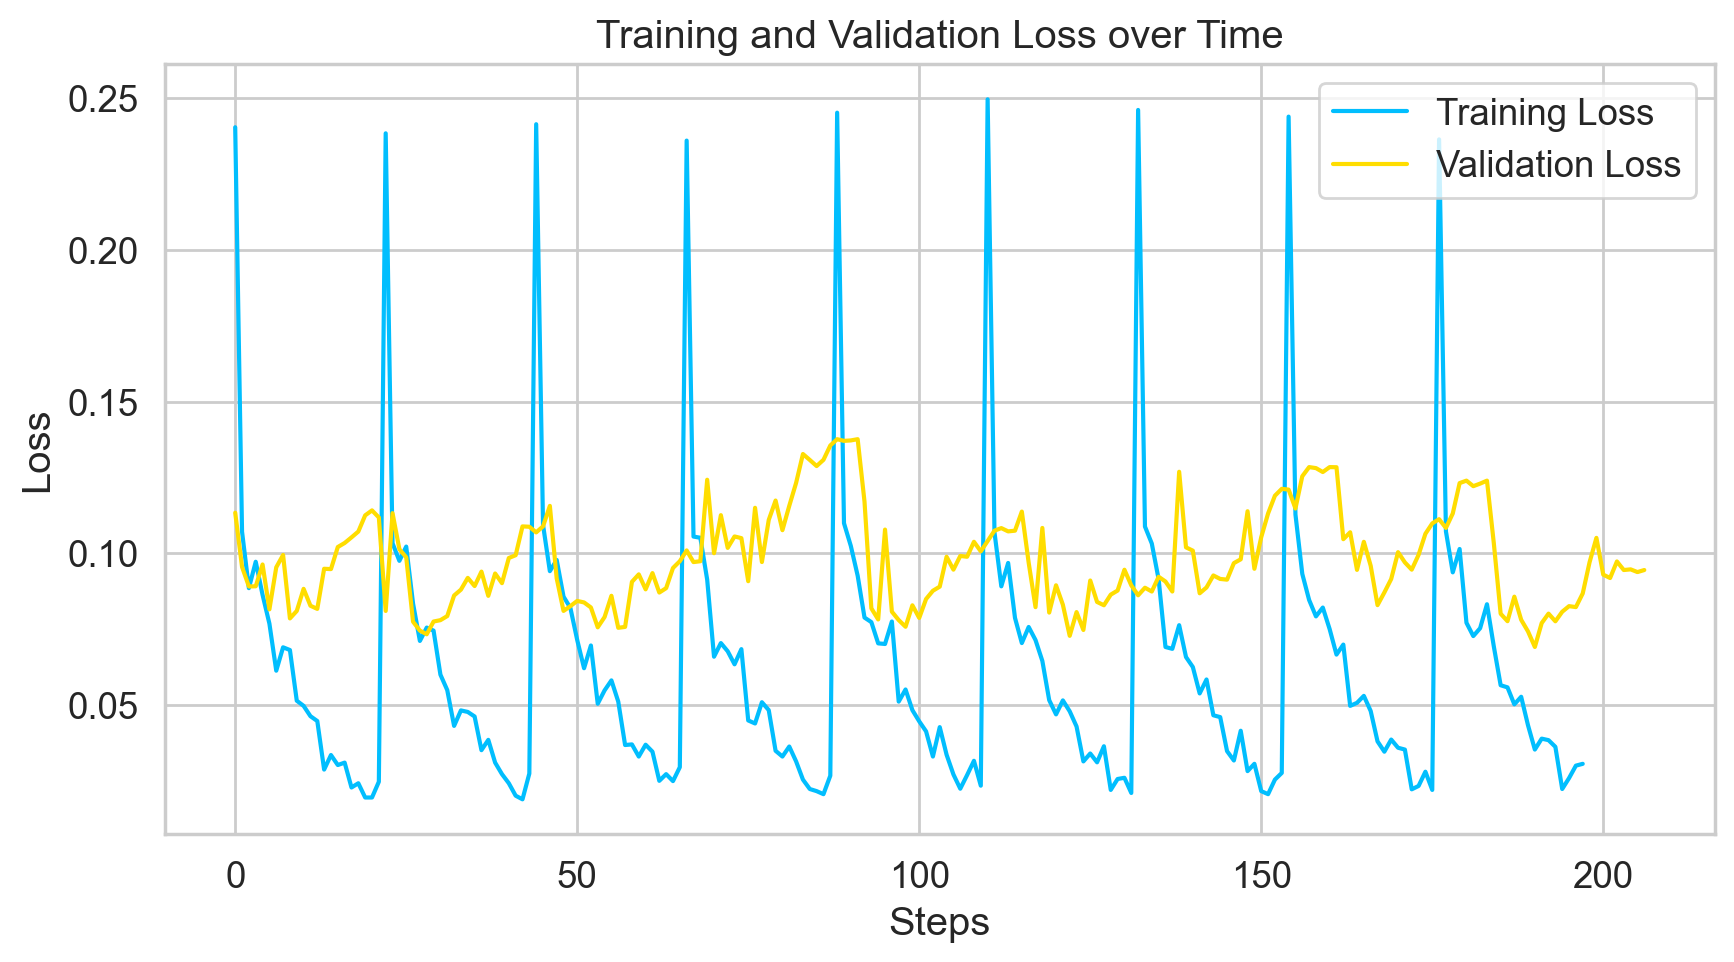

Training fold 10/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/roberta-llama3.1405B-twitter-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Weighted accuracy,F1,Precision,Recall
50,0.244000,0.115305,0.891304,0.973807,0.428148,0.465341,0.414260
100,0.115900,0.094700,0.895141,0.953409,0.516060,0.533331,0.512760
150,0.100300,0.080405,0.906650,0.962468,0.516785,0.511483,0.522270
200,0.079100,0.082071,0.883632,0.917077,0.565614,0.544134,0.609602
250,0.085900,0.075130,0.916880,0.962245,0.547143,0.528751,0.567943
300,0.064600,0.087349,0.870844,0.887871,0.628706,0.578477,0.725997
350,0.084300,0.071999,0.907928,0.949317,0.609384,0.637349,0.608913
400,0.073100,0.073588,0.909207,0.934955,0.663433,0.667445,0.691443
450,0.069900,0.073260,0.907928,0.936116,0.656102,0.651225,0.681667
500,0.047900,0.081690,0.911765,0.949380,0.659719,0.662980,0.659341


D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\User\anaconda3\envs\cu121torch230\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training took: 272.98 seconds


Average results: {'eval_loss': 0.10481115058064461, 'eval_Accuracy': 0.897689880549921, 'eval_Weighted Accuracy': 0.9391536391636073, 'eval_F1': 0.6662355018374887, 'eval_Precision': 0.6710489346762532, 'eval_Recall': 0.6673095499493787, 'eval_runtime': 1.2849400000000002, 'eval_samples_per_second': 640.0776, 'eval_steps_per_second': 20.4389, 'epoch': 5.0}


In [12]:
from sklearn.model_selection import KFold

# k折交叉验证
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.1, stratify=labels, random_state=seed)
results = []
fold_counter = 1
for train_index, val_index in kf.split(train_texts):
    print(f"Training fold {fold_counter}/{k}")
    fold_train_texts = [train_texts[i] for i in train_index]
    fold_val_texts = [train_texts[i] for i in val_index]
    fold_train_labels = [train_labels[i] for i in train_index]
    fold_val_labels = [train_labels[i] for i in val_index]

    train_dataset = MyDataset(tokenizer(fold_train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_train_labels)
    val_dataset = MyDataset(tokenizer(fold_val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), fold_val_labels)

    # 独立的k次训练
    model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)

    # 定义训练参数
    training_args = TrainingArguments(
        output_dir=f'./results/{base_model_name}',          # 输出结果目录
        report_to='none',
        num_train_epochs=num_epochs,
        learning_rate=lr,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        # warmup_steps=warmup_steps,
        logging_strategy='steps',
        logging_dir=f'./logs/{base_model_name}',            # 日志目录
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=50,
        disable_tqdm=False,
        save_strategy="steps",
        fp16= torch.cuda.is_available(), # faster and use less memory
        metric_for_best_model='F1',
        load_best_model_at_end=True,
        greater_is_better=True,
        # push_to_hub=True,
        # label_smoothing_factor=label_smoothing_factor
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_type=loss_type,  # 自定义参数 focal_loss dsc_loss
        callbacks=[loss_recorder]
    )

    start = time.time()
    trainer.train()
    train_time = time.time() - start
    print(f"Training took: {train_time:.2f} seconds")
    eval_result = trainer.evaluate()
    results.append(eval_result)

    loss_recorder.plot_losses()
    fold_counter += 1

# 计算平均结果
avg_results = {key: np.mean([result[key] for result in results]) for key in results[0]}
print("Average results:", avg_results)

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

In [15]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import json

test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
test_results = trainer.evaluate(test_dataset)

results_json = {
    "model_name": base_model_name,
    "avg_results": avg_results,
    "test_results": test_results
}

results_path = f'./output/bert_output.json'

if not os.path.exists(results_path):
    with open(results_path, 'w') as json_file:
        json.dump({}, json_file)

with open(results_path, 'w') as json_file:
    json.dump(results_json, json_file, indent=4)

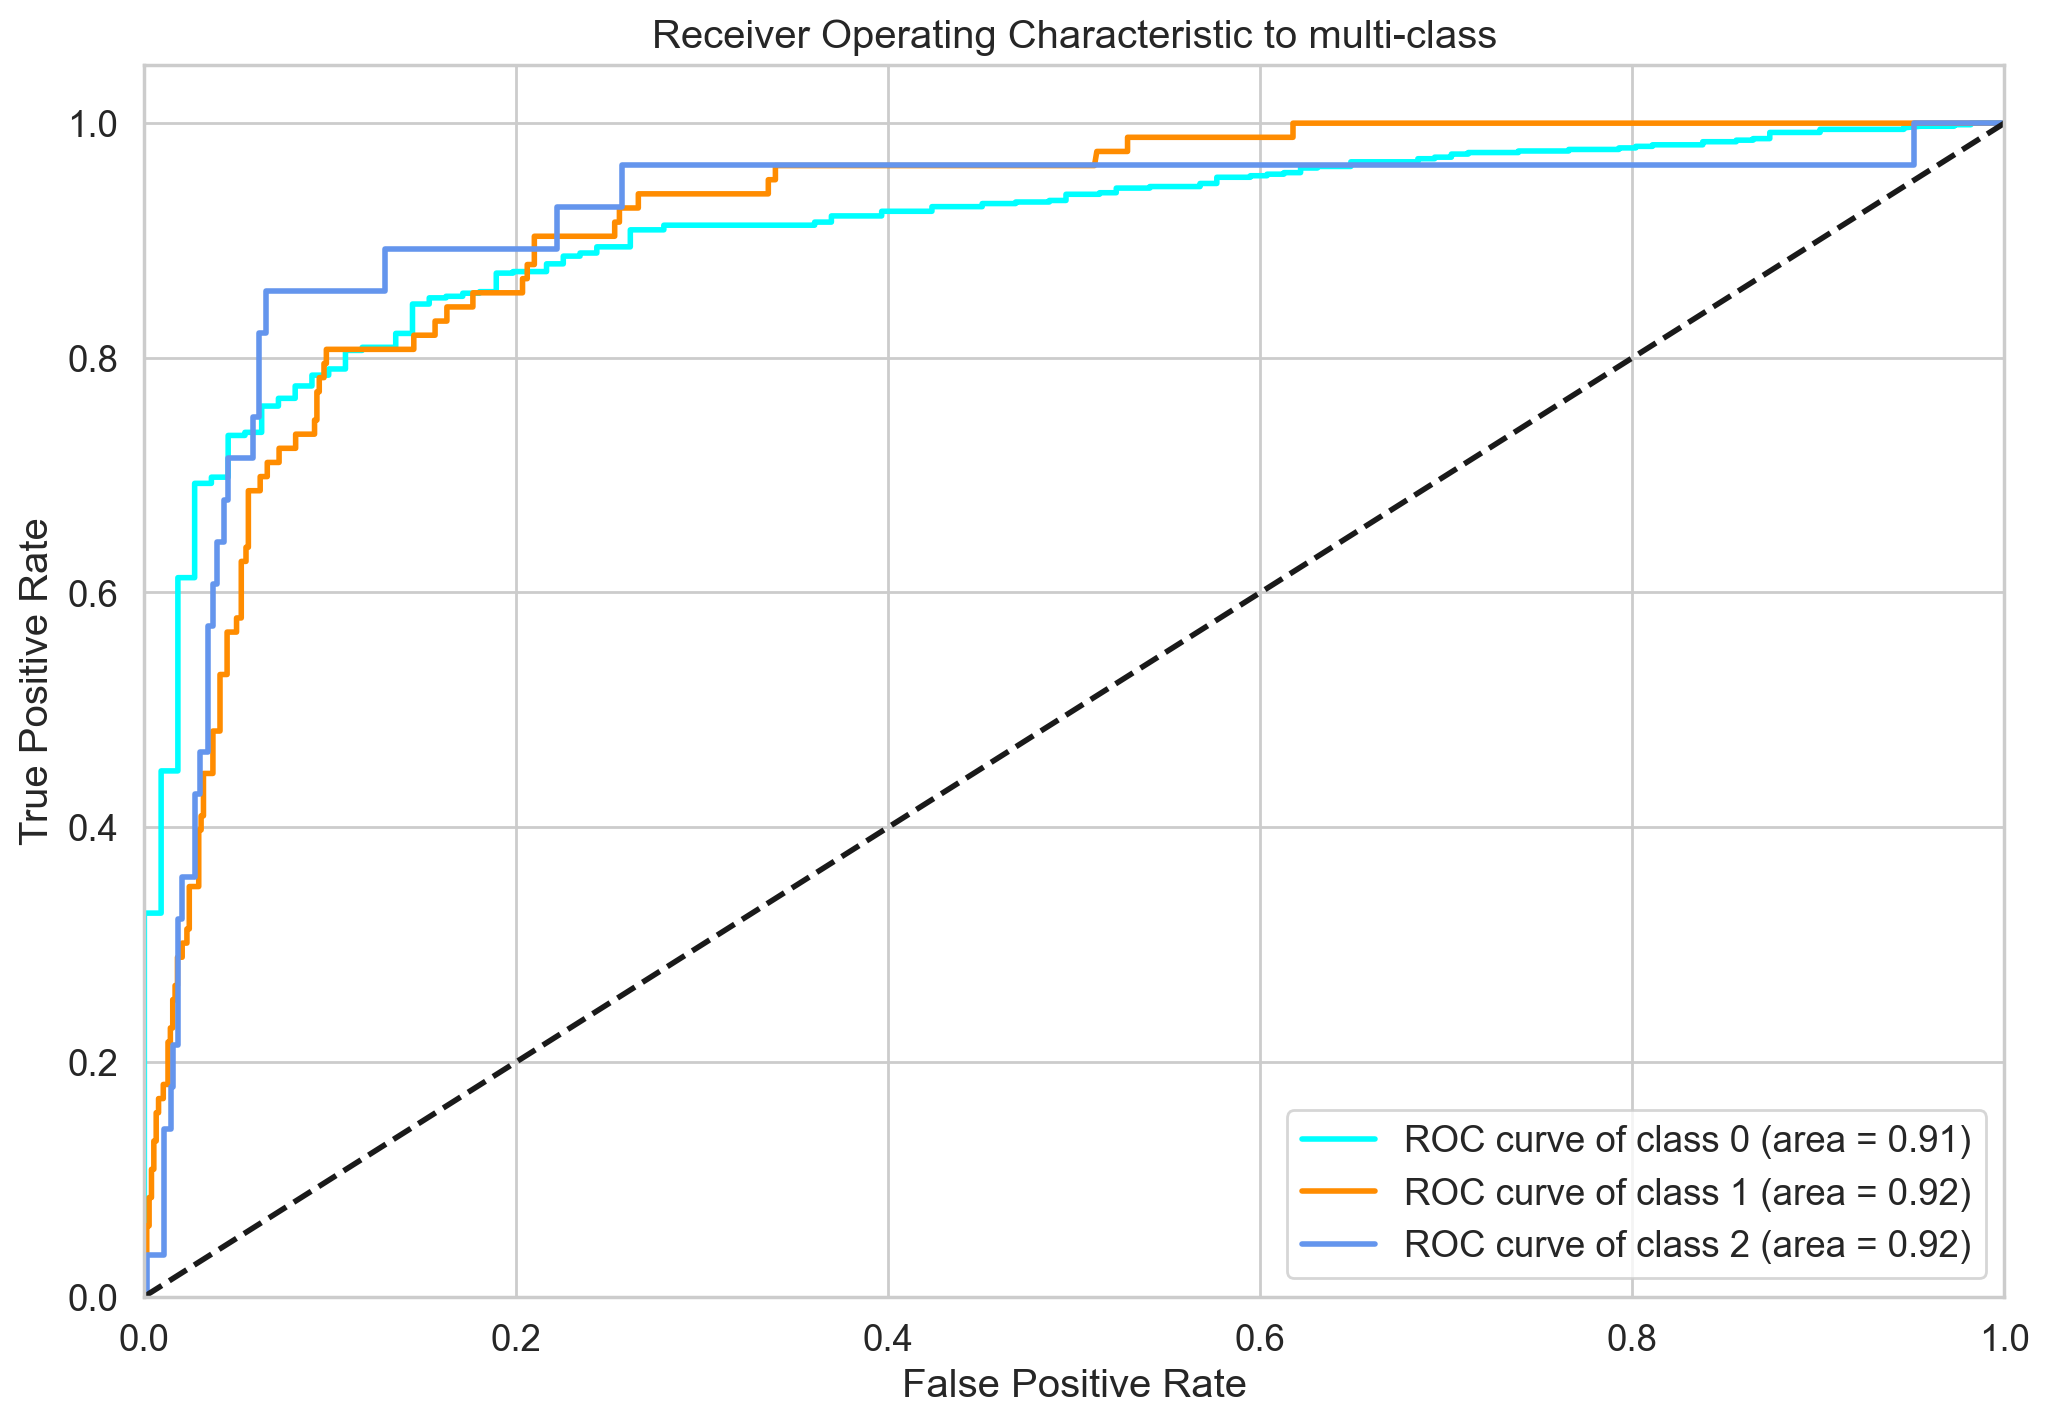

In [16]:
def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
plot_roc_curve(test_labels, probs)

## PR曲线

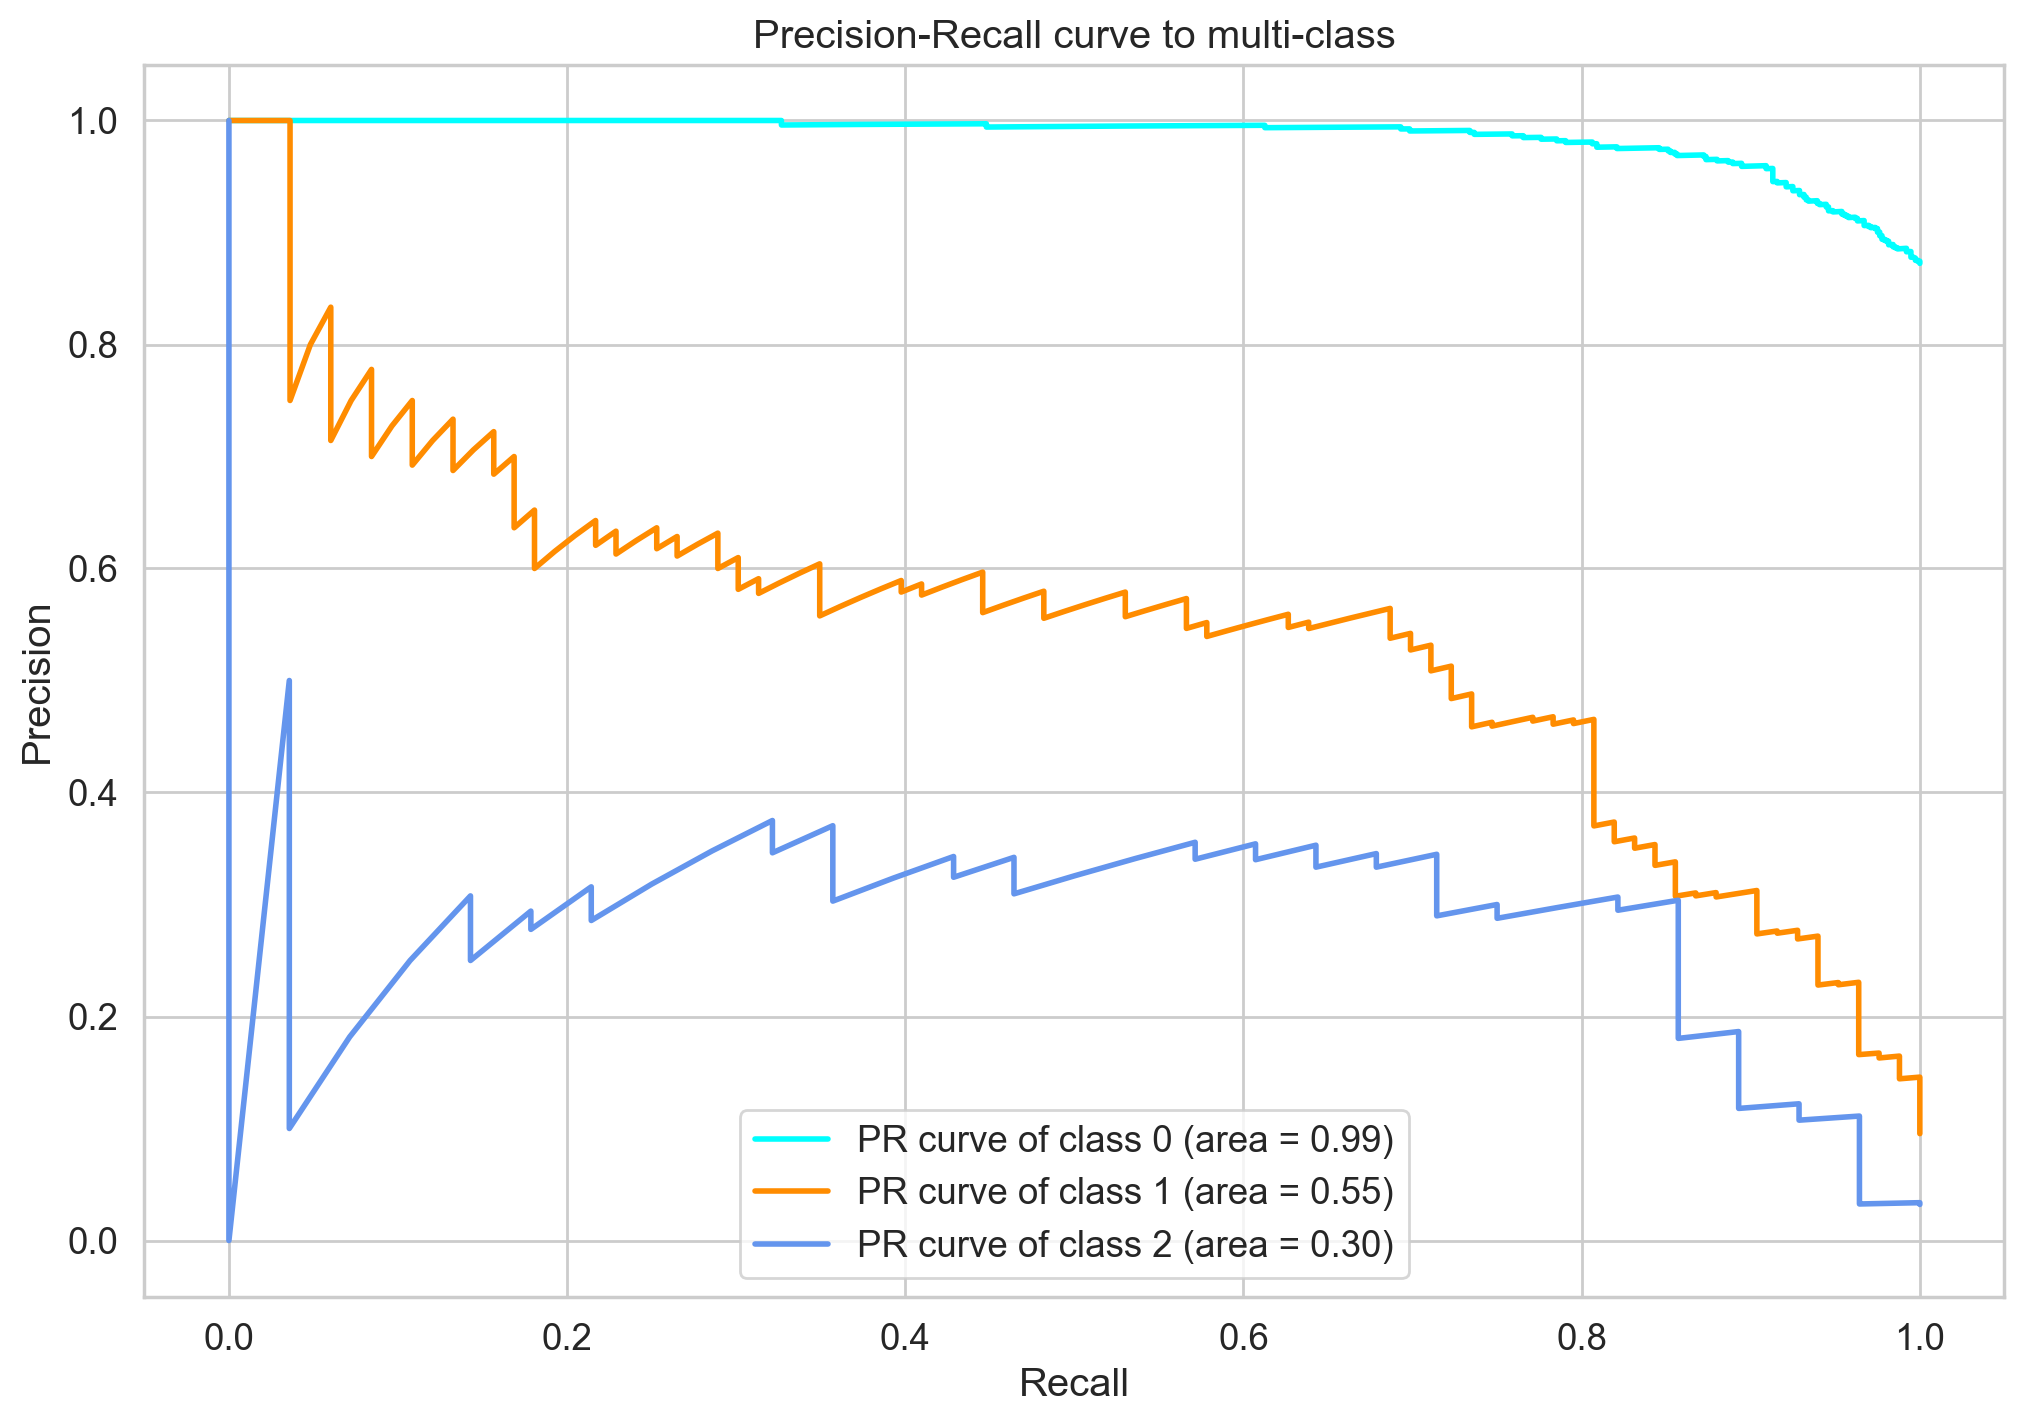

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

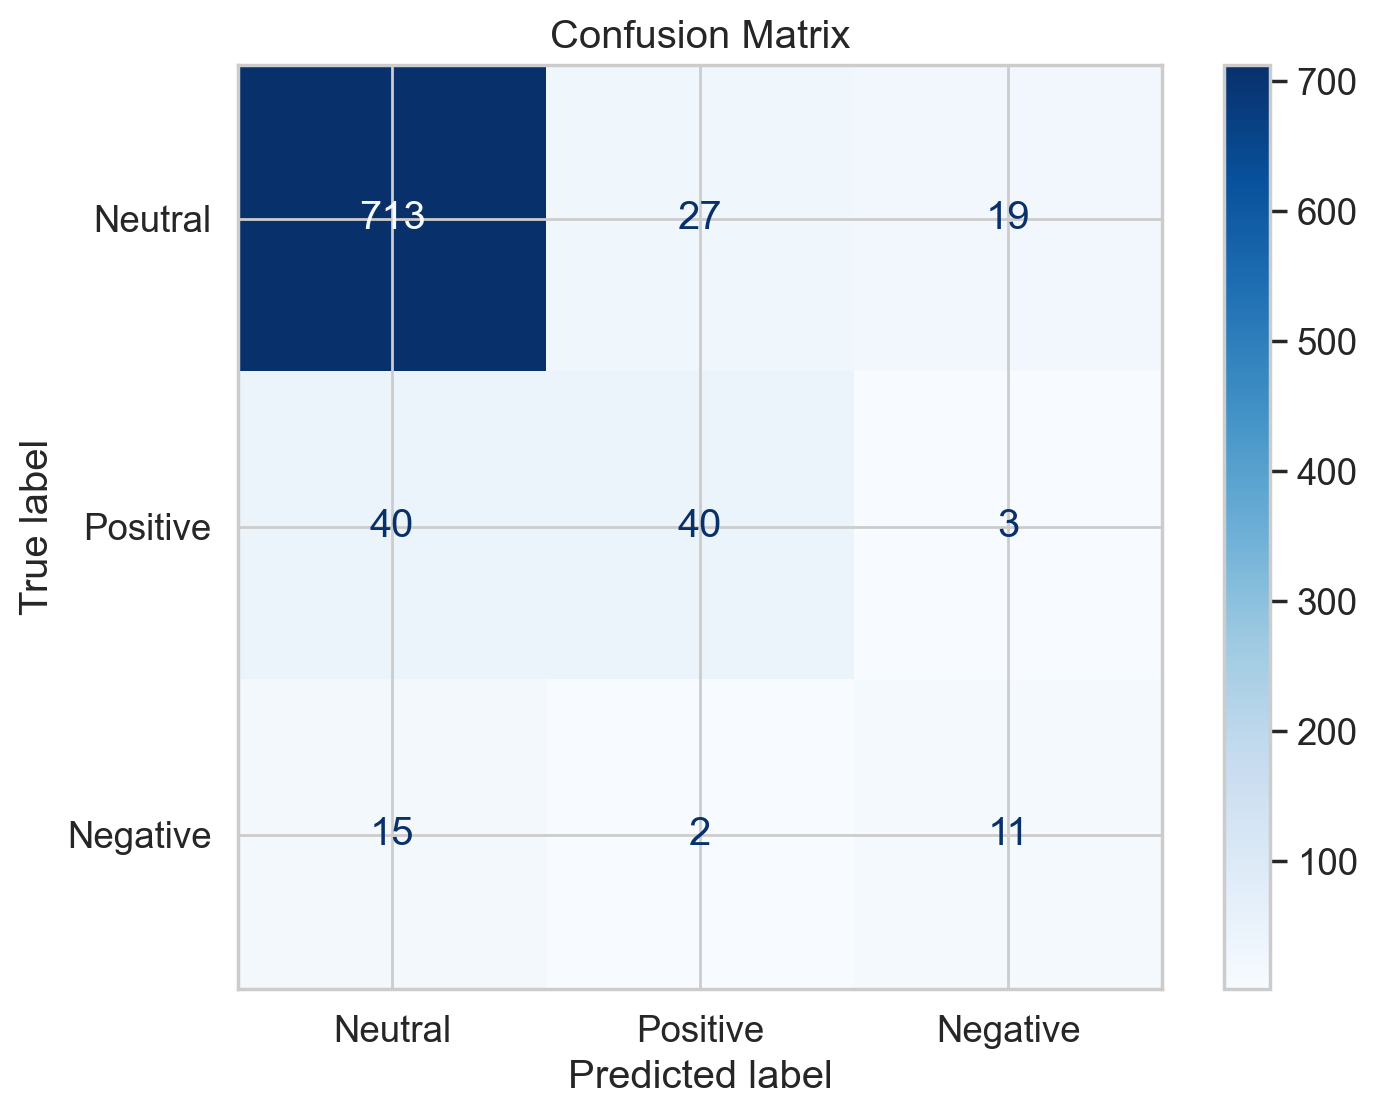

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 误差分析

In [19]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        if loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(output.logits, batch["label"].to(device))

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

tokenized_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_data["validation"] = tokenized_data["validation"].map(forward_pass_with_label, batched=True, batch_size=16)
tokenized_data.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_data["validation"][:][cols]
df_test["label"] = df_test["label"].map(id2label)
df_test["predicted_label"] = (df_test["predicted_label"].map(id2label))
df_test.sort_values("loss", ascending=False).head(10)

Parameter 'function'=<function forward_pass_with_label at 0x0000021999322DD0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

,text,label,predicted_label,loss
1215,Many approaches for POS tagging have been deve...,Negative,Neutral,3.953798
1095,Such a quasi-syntactic structure can naturally...,Negative,Neutral,3.823761
745,"To analyze our methods on IV and OOV words, we...",Negative,Neutral,3.730940
1062,Again the best result was obtained with IOB1 (...,Negative,Neutral,3.553555
1192,HMM-smoothing improves on the most closely rel...,Negative,Neutral,3.449133
1337,1 Introduction The field of machine translatio...,Negative,Positive,3.306104
1643,Bilexical context-free grammars have been pres...,Negative,Positive,3.287908
126,Sentence-level approximations to B exist (Lin ...,Negative,Positive,2.280030
576,While in traditional word-based statistical mo...,Negative,Neutral,2.183304
882,Other statistical machine translation systems ...,Negative,Neutral,2.108660


In [20]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
470,"(2008) to LFG parses, and by Liu and Gildea (2...",Neutral,Neutral,0.000122
1107,"(Koo and Collins, 2005; Matsuzaki et al. , 200...",Neutral,Neutral,0.000133
586,"(Brown et al. , 1993; Vogel et al. , 1996; Gar...",Neutral,Neutral,0.000133
1547,"(Koo and Collins, 2005; Matsuzaki et al. , 200...",Neutral,Neutral,0.000134
797,3 Experiments and Results All experiments were...,Neutral,Neutral,0.000137
1582,"For instance, we may find metrics based on ful...",Neutral,Neutral,0.000141
552,Several researchers also studied feature/topic...,Neutral,Neutral,0.000142
250,"Section 3 describes previous work (Friedman, H...",Neutral,Neutral,0.000146
1652,"First, a parsing-based approach attempts to re...",Neutral,Neutral,0.000147
437,"(Pang & Lee, 2004; Aue & Gamon, 2005).",Neutral,Neutral,0.000148


In [21]:
from torch.utils.data import DataLoader, ConcatDataset

best_model_dir = f'./citation_finetuned_models/{base_model_name}'
trainer.save_model(best_model_dir)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)
